In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from fastdtw import fastdtw

In [2]:
LENGTH = 22000
OFFSET = 4000

In [3]:
def get_signals(dir, max_no_signals = 10):
    '''
    gets signals from specified directory 
    and returns a (n, l, 1) numpy array
    where n is number of distinct signals and
    l is length of each signal.
    '''
    directory = dir

    list_of_signals = []

    n = 0

    for filename in os.listdir(directory):
        filename = directory + '/' + filename
        list_of_signals.append(np.genfromtxt(filename, delimiter=','))
        n+=1
    
    no_signals = len(list_of_signals) # comment out if doing subsampling for testing
    
    signals = np.zeros([no_signals-1, LENGTH])   # replace 5 with n ! 
    
    for i, arr in enumerate(list_of_signals[1:(no_signals-1)]):
        arr = arr[OFFSET:LENGTH+OFFSET]
        signals[i][0:arr.shape[0]] = arr

    print("Signals loaded. Length of a signal is %d, No. of signals is: %d" % (len(signals[0]), no_signals-1))
    return signals, no_signals - 1

def plot_signals(signals, name):
    avg = np.average(signals, axis=0)
    std = np.std(signals, axis=0)
    x = range(signals.shape[1])

    plt.style.use('ggplot') #Change/Remove This If you Want
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, avg, alpha=0.5, color='red', label=name, linewidth = 1.0)
    ax.fill_between(x, avg - std, avg + std, color='#888888', alpha=0.4)
    ax.fill_between(x, avg - 2*std, avg + 2* std, color='#888888', alpha=0.2)
    ax.legend(loc='best')
    ax.set_ylabel("Signal units?")
    ax.set_xlabel("Time")
    plt.show()
    
def plot_sig(sigs, n=10):
    plt.figure(figsize=(15,10))
    for sig in sigs[0:n]:
        plt.plot(sig)
    plt.show()

Signals loaded. Length of a signal is 22000, No. of signals is: 459


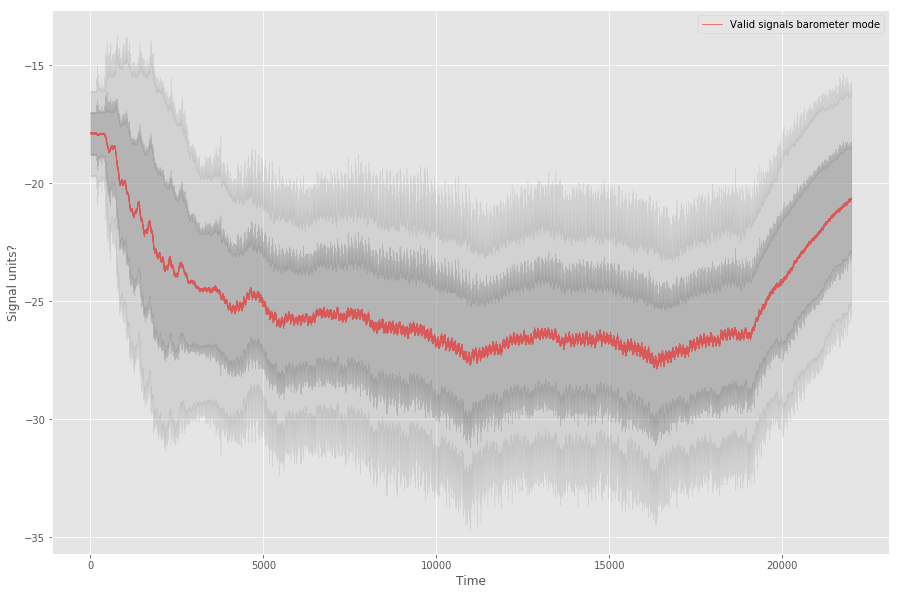

In [5]:
valid_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL_VALID_SWEEP_bar-active')
plot_signals(valid_bar, 'Valid signals barometer mode')

In [9]:
div = 100

def downsample(s, R):
    s = s.reshape(-1, R)
    return s.reshape(-1, R).mean(axis=1)

def downsample_signals(signals):
    downsampled_signals = np.zeros([signals.shape[0], LENGTH//div])
    
    for i, signal in enumerate(signals):
        downsampled_signals[i] = downsample(signal, div)
        
    return downsampled_signals

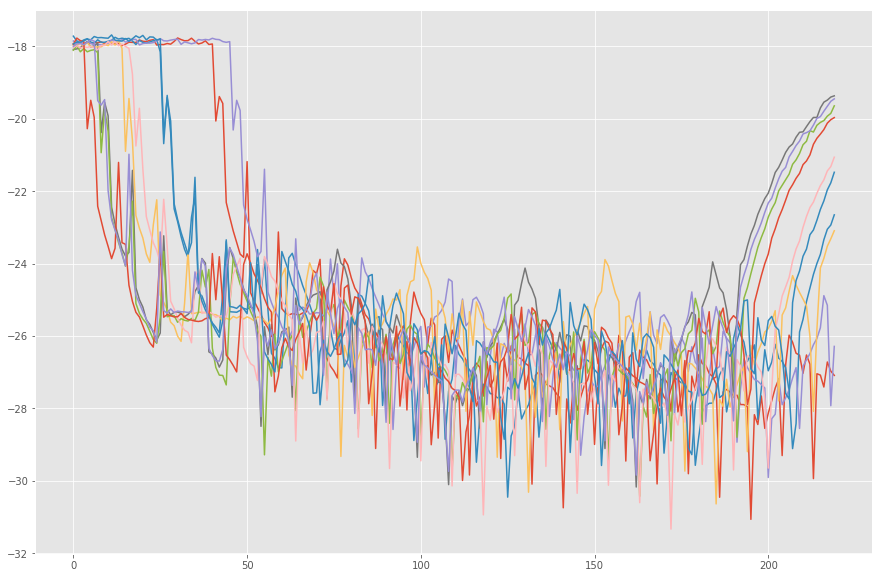

In [10]:
downsampled_signals = downsample_signals(valid_bar)
plot_sig(downsampled_signals)

Signals loaded. Length of a signal is 22000, No. of signals is: 98


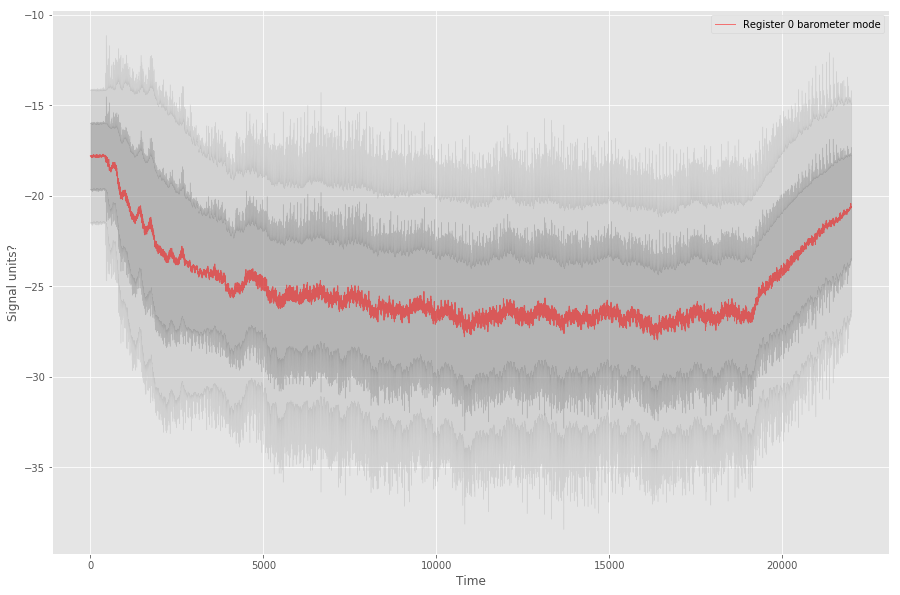

In [11]:
reg0_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-bar-active')
plot_signals(reg0_bar, 'Register 0 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 98


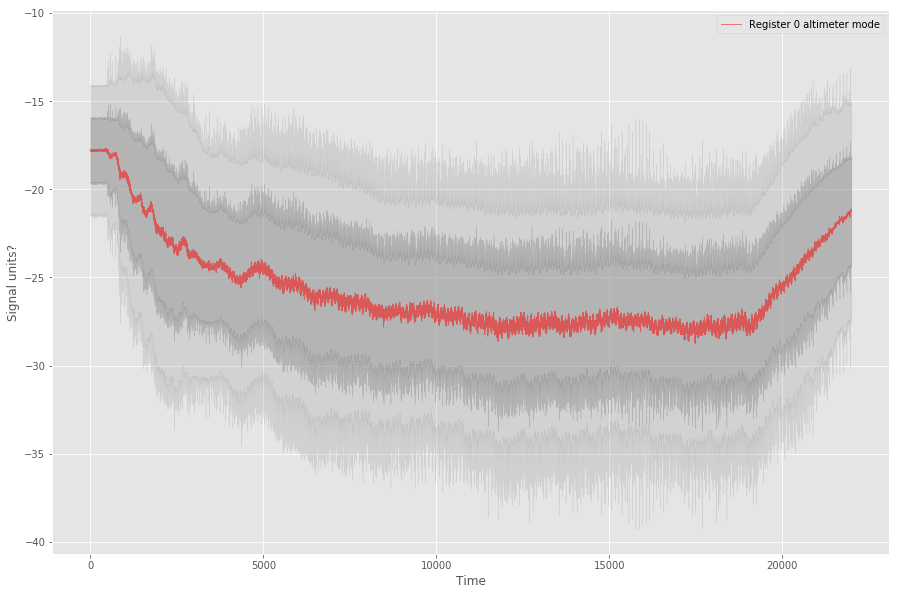

In [12]:
reg0_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-alt-active')
plot_signals(reg0_alt, 'Register 0 altimeter mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 409


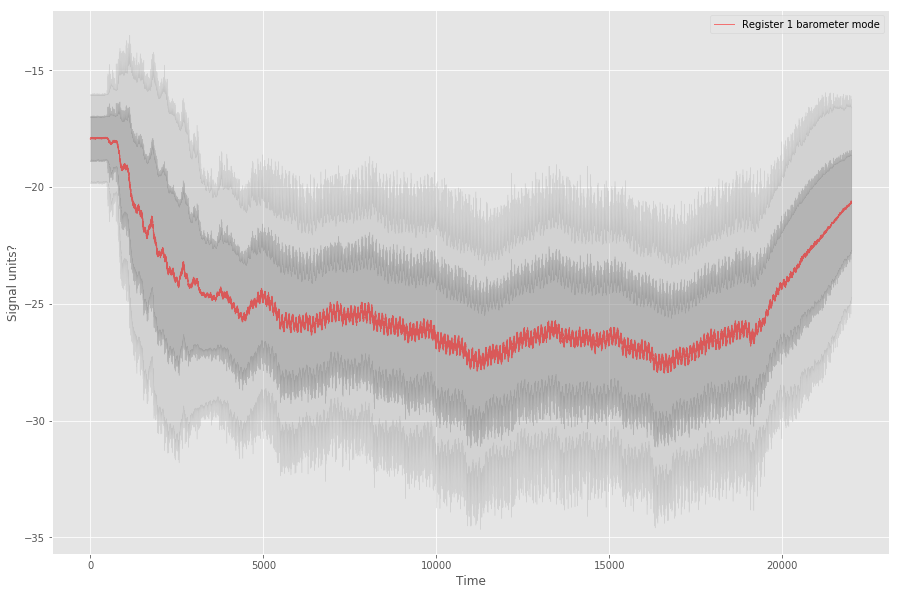

In [13]:
reg1_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-bar-active')
plot_signals(reg1_bar, 'Register 1 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 397


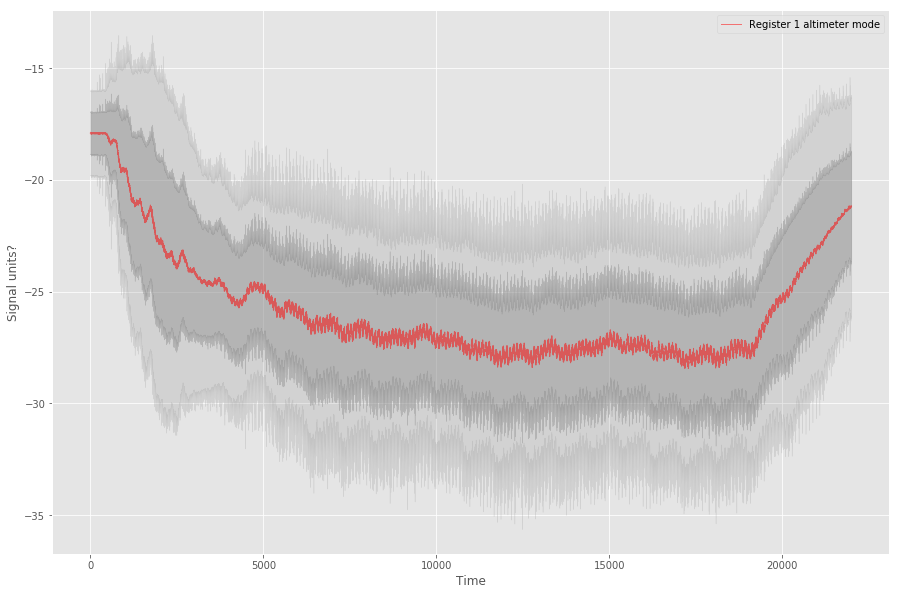

In [15]:
reg1_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-alt-active')
plot_signals(reg1_alt, 'Register 1 altimeter mode')

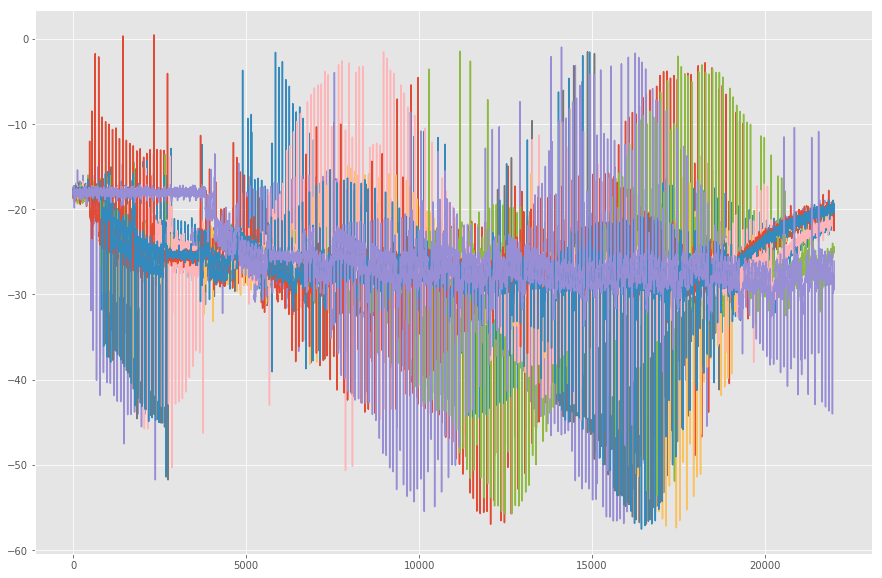

In [16]:
plot_sig(reg1_alt)

In [26]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, GlobalAveragePooling1D, Input, UpSampling1D
from keras.utils import to_categorical
from keras import regularizers

Using TensorFlow backend.


In [126]:
# create train/test split (3/4)

size=200
x = np.concatenate((downsample_signals(reg1_bar[0:size]), downsample_signals(reg1_alt[0:size])),axis=0)
                    #downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)
x0 = np.concatenate((downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)
    
y1 = np.zeros(size)
y2 = np.ones(size)
y3 = np.ones(size)+1
y4 = np.ones(size)+2
#y = to_categorical(np.concatenate((y1,y2,y3,y4)))
y = np.concatenate((y1,y2)).reshape(-1,1)

print(x.shape)
print(y.shape)

def split(arr, n = len(x) - len(x)//4):
    return arr[:n], arr[n:]

def random_split(x, y, dim_out=1):
    """shuffle data, train/test split. returns train_x, train_y, test_x, test_y"""
    tmp = np.concatenate((x,y), axis=1)
    np.random.shuffle(tmp)
    train, test = split(tmp)
    return train[:,:-dim_out], train[:,-dim_out:], test[:,:-dim_out], test[:,-dim_out:]

train_x, train_y, test_x, test_y = random_split(x,y, y.shape[1])

seq_length, n_features, n_outputs = train_x.shape[1], 1, y.shape[1]
print("Sequence length is", seq_length)

train_x = train_x.reshape(-1,seq_length, n_features)
test_x = test_x.reshape(-1, seq_length, n_features)
print(train_x.shape)
print(train_y.shape)


(400, 220)
(400, 1)
Sequence length is 220
(300, 220, 1)
(300, 1)


In [88]:
verbose, epochs, batch_size = 1, 100, 4

model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=16, kernel_size=10, activation='relu', input_shape=(seq_length, n_features)),
    MaxPooling1D(),     # Downsample the output of convolution by 2X.
    Conv1D(filters=16, kernel_size=10, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(n_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
                                                # For others, use 'softmax'
))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# for binary classification use binary_crossentropy
# for multiple use categorical_crossentropy

In [89]:
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = True)

Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 0.9906 - acc: 0.4967
Epoch 2/100
300/300 [==============================] - 0s 612us/step - loss: 0.6984 - acc: 0.5500
Epoch 3/100
300/300 [==============================] - 0s 557us/step - loss: 0.6652 - acc: 0.6033
Epoch 4/100
300/300 [==============================] - 0s 555us/step - loss: 0.6785 - acc: 0.5900
Epoch 5/100
300/300 [==============================] - 0s 510us/step - loss: 0.6856 - acc: 0.6267
Epoch 6/100
300/300 [==============================] - 0s 529us/step - loss: 0.6747 - acc: 0.6533
Epoch 7/100
300/300 [==============================] - 0s 548us/step - loss: 0.6688 - acc: 0.7033
Epoch 8/100
300/300 [==============================] - 0s 515us/step - loss: 0.6566 - acc: 0.7100
Epoch 9/100
300/300 [==============================] - 0s 507us/step - loss: 0.6514 - acc: 0.6767
Epoch 10/100
300/300 [==============================] - 0s 670us/step - loss: 0.6254 - acc: 0.6933
Epoch 11/100
300/300 

300/300 [==============================] - 0s 520us/step - loss: 0.1337 - acc: 0.9500
Epoch 84/100
300/300 [==============================] - 0s 463us/step - loss: 0.1304 - acc: 0.9500
Epoch 85/100
300/300 [==============================] - 0s 477us/step - loss: 0.1347 - acc: 0.9500
Epoch 86/100
300/300 [==============================] - 0s 464us/step - loss: 0.1635 - acc: 0.9367
Epoch 87/100
300/300 [==============================] - 0s 458us/step - loss: 0.1355 - acc: 0.9433
Epoch 88/100
300/300 [==============================] - 0s 450us/step - loss: 0.1389 - acc: 0.9333
Epoch 89/100
300/300 [==============================] - 0s 463us/step - loss: 0.1284 - acc: 0.9633
Epoch 90/100
300/300 [==============================] - 0s 451us/step - loss: 0.1455 - acc: 0.9567
Epoch 91/100
300/300 [==============================] - 0s 457us/step - loss: 0.1089 - acc: 0.9633
Epoch 92/100
300/300 [==============================] - 0s 464us/step - loss: 0.1156 - acc: 0.9567
Epoch 93/100
300/300 [=

In [90]:
_, accuracy = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

0.97
0.96


In [91]:
def dtw(x, y):
    distance, path = fastdtw(x, y, dist=1)
    return distance

/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


12767.919921460227

In [128]:
reg1_bar_downsampled = downsample_signals(reg1_bar)
reg1_alt_downsampled = downsample_signals(reg1_alt)
print("REG 1")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_alt_downsampled[i]))
print("=======REG 0=======")
reg0_bar_downsampled = downsample_signals(reg0_bar)
reg0_alt_downsampled = downsample_signals(reg0_alt)

for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_alt_downsampled[i]))

REG 1
113.69189453107603
67.73559570357801
70.75500488161697
78.103881836431
--------------
133.8430175780071
146.85913086012695
137.47619629007502
136.89575195401605
=======REG 0=======
92.43359375088193
55.54345703082794
104.06713867198408
94.35473632832782
--------------
111.54687500033786
131.71411132809104
145.24853515698192
177.3574218745809


/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [129]:
from sklearn.cluster import DBSCAN
clus= DBSCAN(eps=60, min_samples=3, metric=dtw).fit(x0)

/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  
/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [130]:
unique, counts = np.unique(clus.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 4, 0: 95, 1: 97}

Cluster 0 number of entries 95


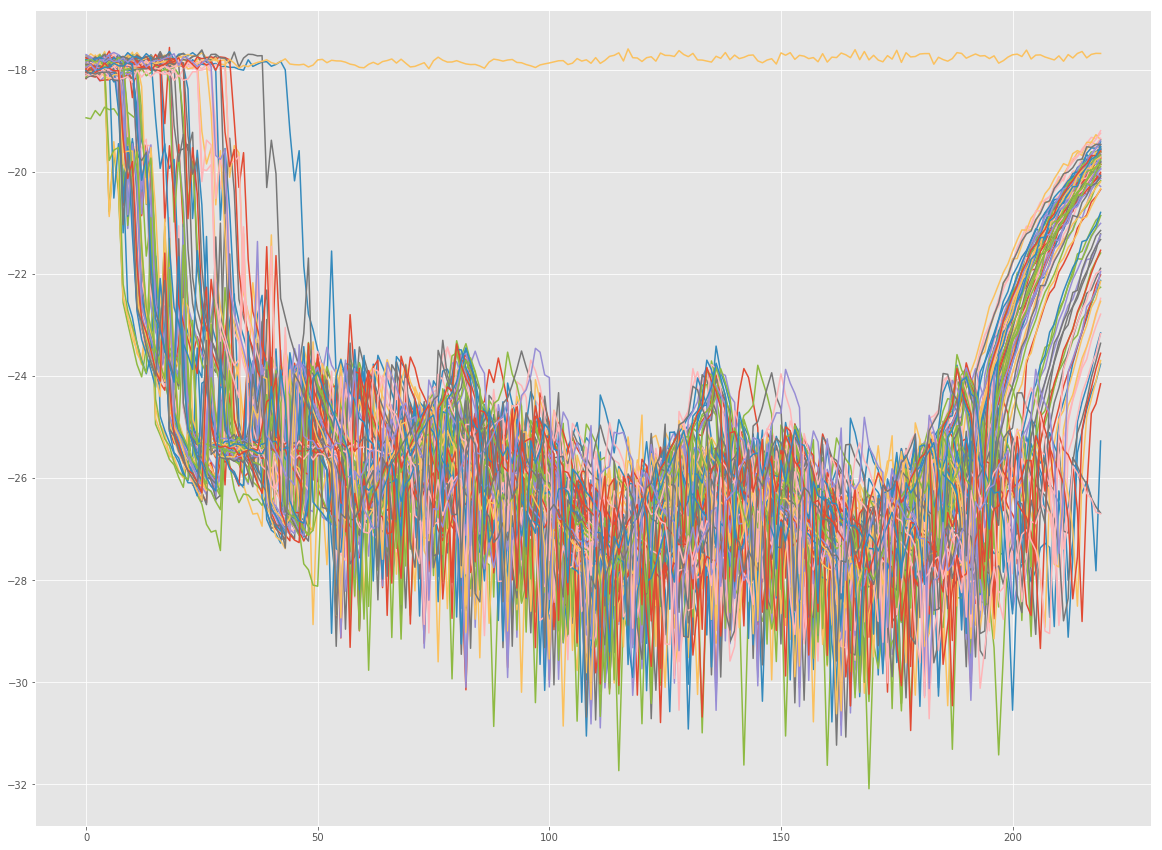

Cluster -1 number of entries 4


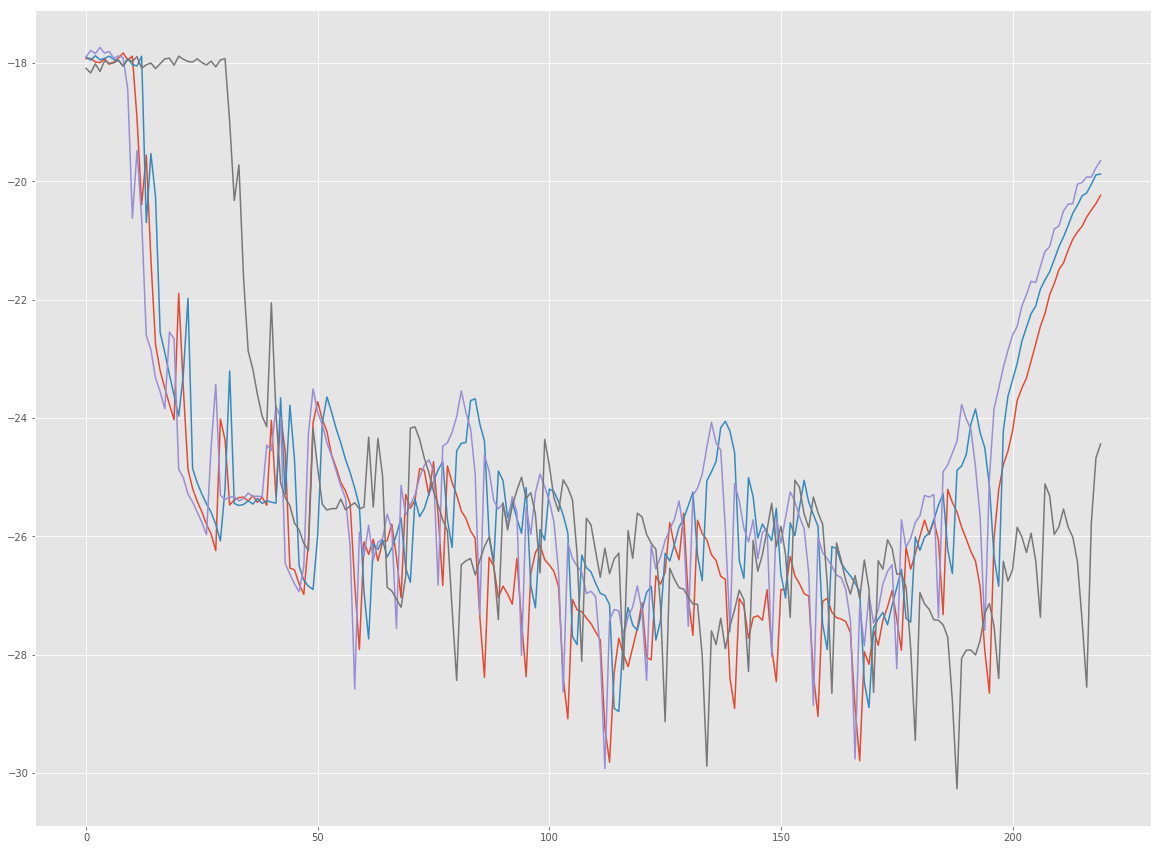

Cluster 1 number of entries 97


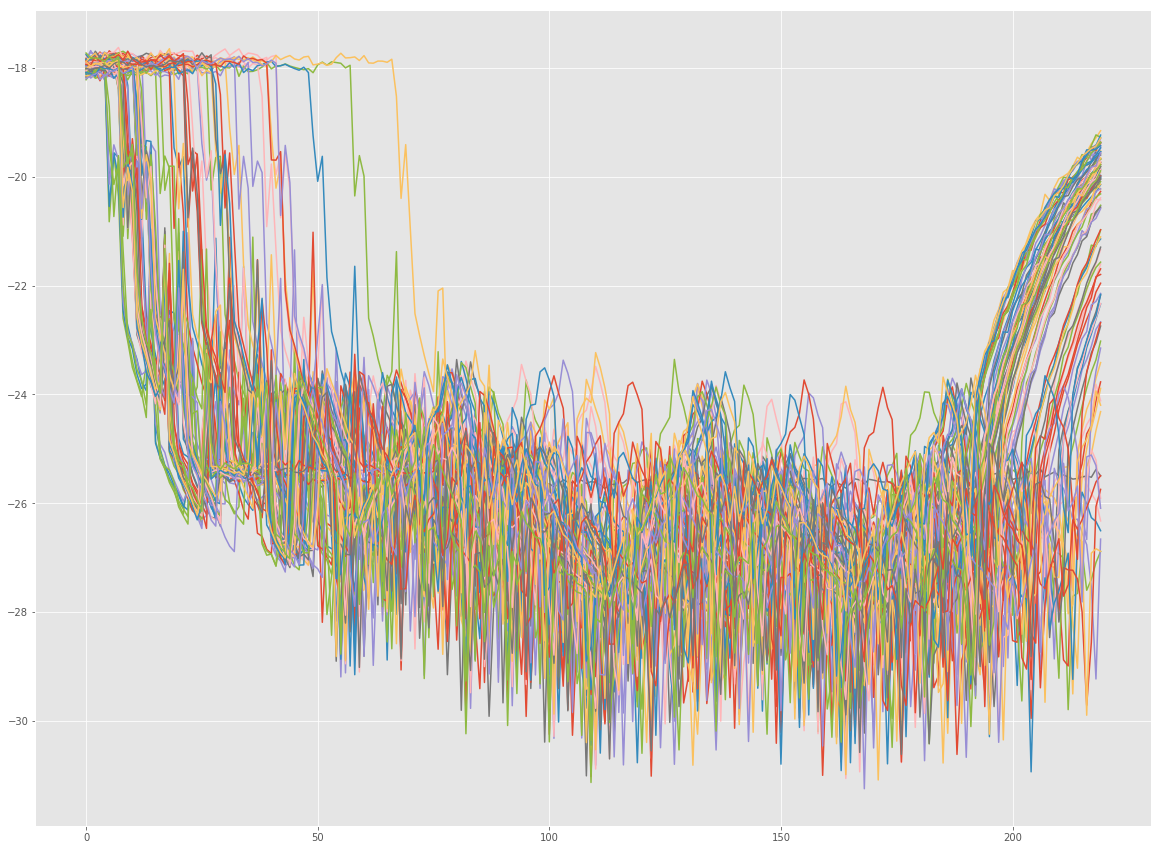

In [131]:
def plot_clusters(data, labels):
    import pandas as pd

    timeSeries = pd.DataFrame(data = data)

    # check the results
    s = pd.Series(labels)
    clusters = s.unique()

    for c in clusters:
        cluster_indices = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indices)))
        timeSeries.T.iloc[:,cluster_indices].plot(figsize=(20,15), legend=False)
        plt.show()
        
plot_clusters(x, clus.labels_)